In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from getdist import plots, MCSamples
import matplotlib 
import dill
%matplotlib inline

np.set_printoptions(precision = 2)

plt.rc('text', usetex=True)
plt.matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

### Load MCMC Samples
In the file, we have the samples in the following format:
$$
\left[\Omega_{\textrm{cdm}}h^{2},\,\Omega_{\textrm{b}}h^{2},\,\textrm{ln}\left(10^{10}A_{\textrm{s}}\right),\,n_{\textrm{s}},\,h,\,A_{\textrm{bary}},\,A_{1},\,A_{2},\,A_{3},\,A_{\textrm{IA}},\,m,\,\Sigma m_{\nu},\,\textrm{ln}p\right]
$$

In [2]:
samples_class    = np.load('mcmc_samples/bandpowers_class_mcmc_samples.npy')
samples_emu_mean = np.load('mcmc_samples/bandpowers_emulator_mean_mcmc_samples.npy')
samples_emu_err  = np.load('mcmc_samples/bandpowers_emulator_error_mcmc_samples.npy')

In [3]:
class_max_lnprob = np.max(samples_class[:,-1])

### Plot log-Posterior

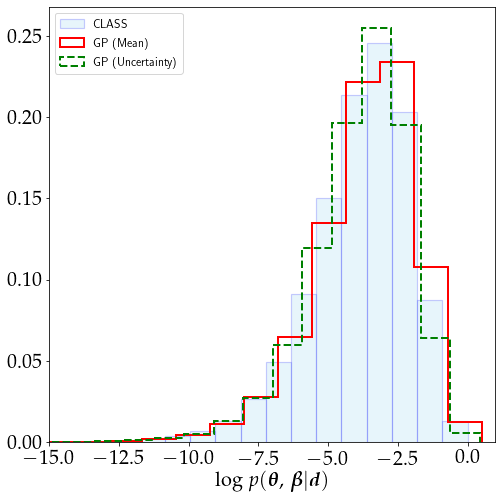

In [4]:
plt.figure(figsize = (8,8))
plt.hist(samples_class[:,-1]-class_max_lnprob, density = True, bins = 20, edgecolor='blue', linewidth=1.2, color = 'skyblue', alpha = 0.2, label = 'CLASS')
plt.hist(samples_emu_mean[:,-1]-class_max_lnprob, density = True, bins = 20, edgecolor='red', linewidth=2, histtype='step', label = 'GP (Mean)')
plt.hist(samples_emu_err[:,-1]-class_max_lnprob, density = True, bins = 20, edgecolor='green', linewidth=2, histtype='step', label = 'GP (Uncertainty)',linestyle=('dashed'))
plt.legend(loc='upper left', prop={'size': 12})
plt.xlabel(r'$\textrm{log }p(\boldsymbol{\theta},\,\boldsymbol{\beta}|\boldsymbol{d})$', fontsize = fontSize)
plt.tick_params(axis = 'both', labelsize = fontSize)
plt.xlim(-15, 1)
plt.show()

### Load $\sigma_{8}$ GP

Note that you might have to retrain the GP (if you are running it in your directory). Check notebook 'example_gp_sigma_eight.ipynb'. Recall that $\sigma_{8}$ is a function of the following parameters:

$$
\left[\Omega_{\textrm{cdm}}h^{2},\,\Omega_{\textrm{b}}h^{2},\,\textrm{ln}\left(10^{10}A_{s}\right),\,n_{s},\,h,\,\Sigma m_{\nu}\right]
$$

In [6]:
sys.path.append('../sigma_eight/')
with open('../sigma_eight/gps/gp_sigma', 'rb') as g:
    sigma = dill.load(g)

### Function to Compute $\sigma_{8}$

We will also return two files, namely for:
+ $S_{8} =\sigma_{8}\sqrt{\Omega_{m}/0.3}$
+ triangle plot with derived parameters

In [9]:
def computeSigmaEight(samples):
    '''
    samples is the original file loaded above - with the log-posterior values in the last column
    '''
    columns     = [0, 1, 2, 3, 4, -2]
    columns_    = [3, 4, 5, 6, 7, 8, 9, 10, 11] # these columns are unchanged
    subset      = samples[:,columns]
    Nsamples    = subset.shape[0]
    sigma_eight = np.zeros(Nsamples)
    
    for i in range(Nsamples):
        sigma_eight[i] = sigma.prediction(subset[i], returnvar=False)
        
    omega_matter = (samples[:,0] + samples[:,1])/samples[:,4]**2
    S_eight      = sigma_eight*np.sqrt(omega_matter/0.3)
    file_1       = np.c_[np.atleast_2d(omega_matter).T, np.atleast_2d(S_eight).T]
    file_2       = np.c_[np.atleast_2d(omega_matter).T, np.atleast_2d(sigma_eight).T, samples[:,columns_]]
    
    return file_1, file_2        

### Compute all required quantities

In [10]:
file_SO_class    , samples_derived_class    = computeSigmaEight(samples_class)
file_SO_emu_mean , samples_derived_emu_mean = computeSigmaEight(samples_emu_mean)
file_SO_emu_err  , samples_derived_emu_err  = computeSigmaEight(samples_emu_err)

### Triangle Plot with the 3 Samples 

In [11]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

ndim     = 11
names    = ["x%s"%i for i in range(ndim)]
labels   =  [r'$\Omega_{m}$',r'$\sigma_{8}$', r'$n_s$', r'$h$',r'$A_{bary}$', r'A_{1}', r'A_{2}', r'A_{3}', r'$A_{IA}$', r'$m$', r'$\Sigma m_{\nu}$']

samples1 = MCSamples(samples=samples_derived_class,names = names, labels = labels)
samples2 = MCSamples(samples=samples_derived_emu_mean,names = names, labels = labels)
samples3 = MCSamples(samples=samples_derived_emu_err,names = names, labels = labels)

sim_color      = '#EEC591'
gp_error_color = '#8B0000'
gp_mean_color  = 'Blue'
alpha_tri      = 0.7
red_patch = mpatches.Patch(color=sim_color, label='CLASS', alpha = alpha_tri)
gp_error  = Line2D([0], [0], color=gp_error_color, linewidth=3, linestyle='-', label = 'GP (Uncertainty)')
gp_mean   = Line2D([0], [0], color=gp_mean_color, linewidth=3, linestyle='--', label = 'GP (Mean)')
rec_leg   = [red_patch, gp_error, gp_mean]

Removed no burn in
Removed no burn in
Removed no burn in


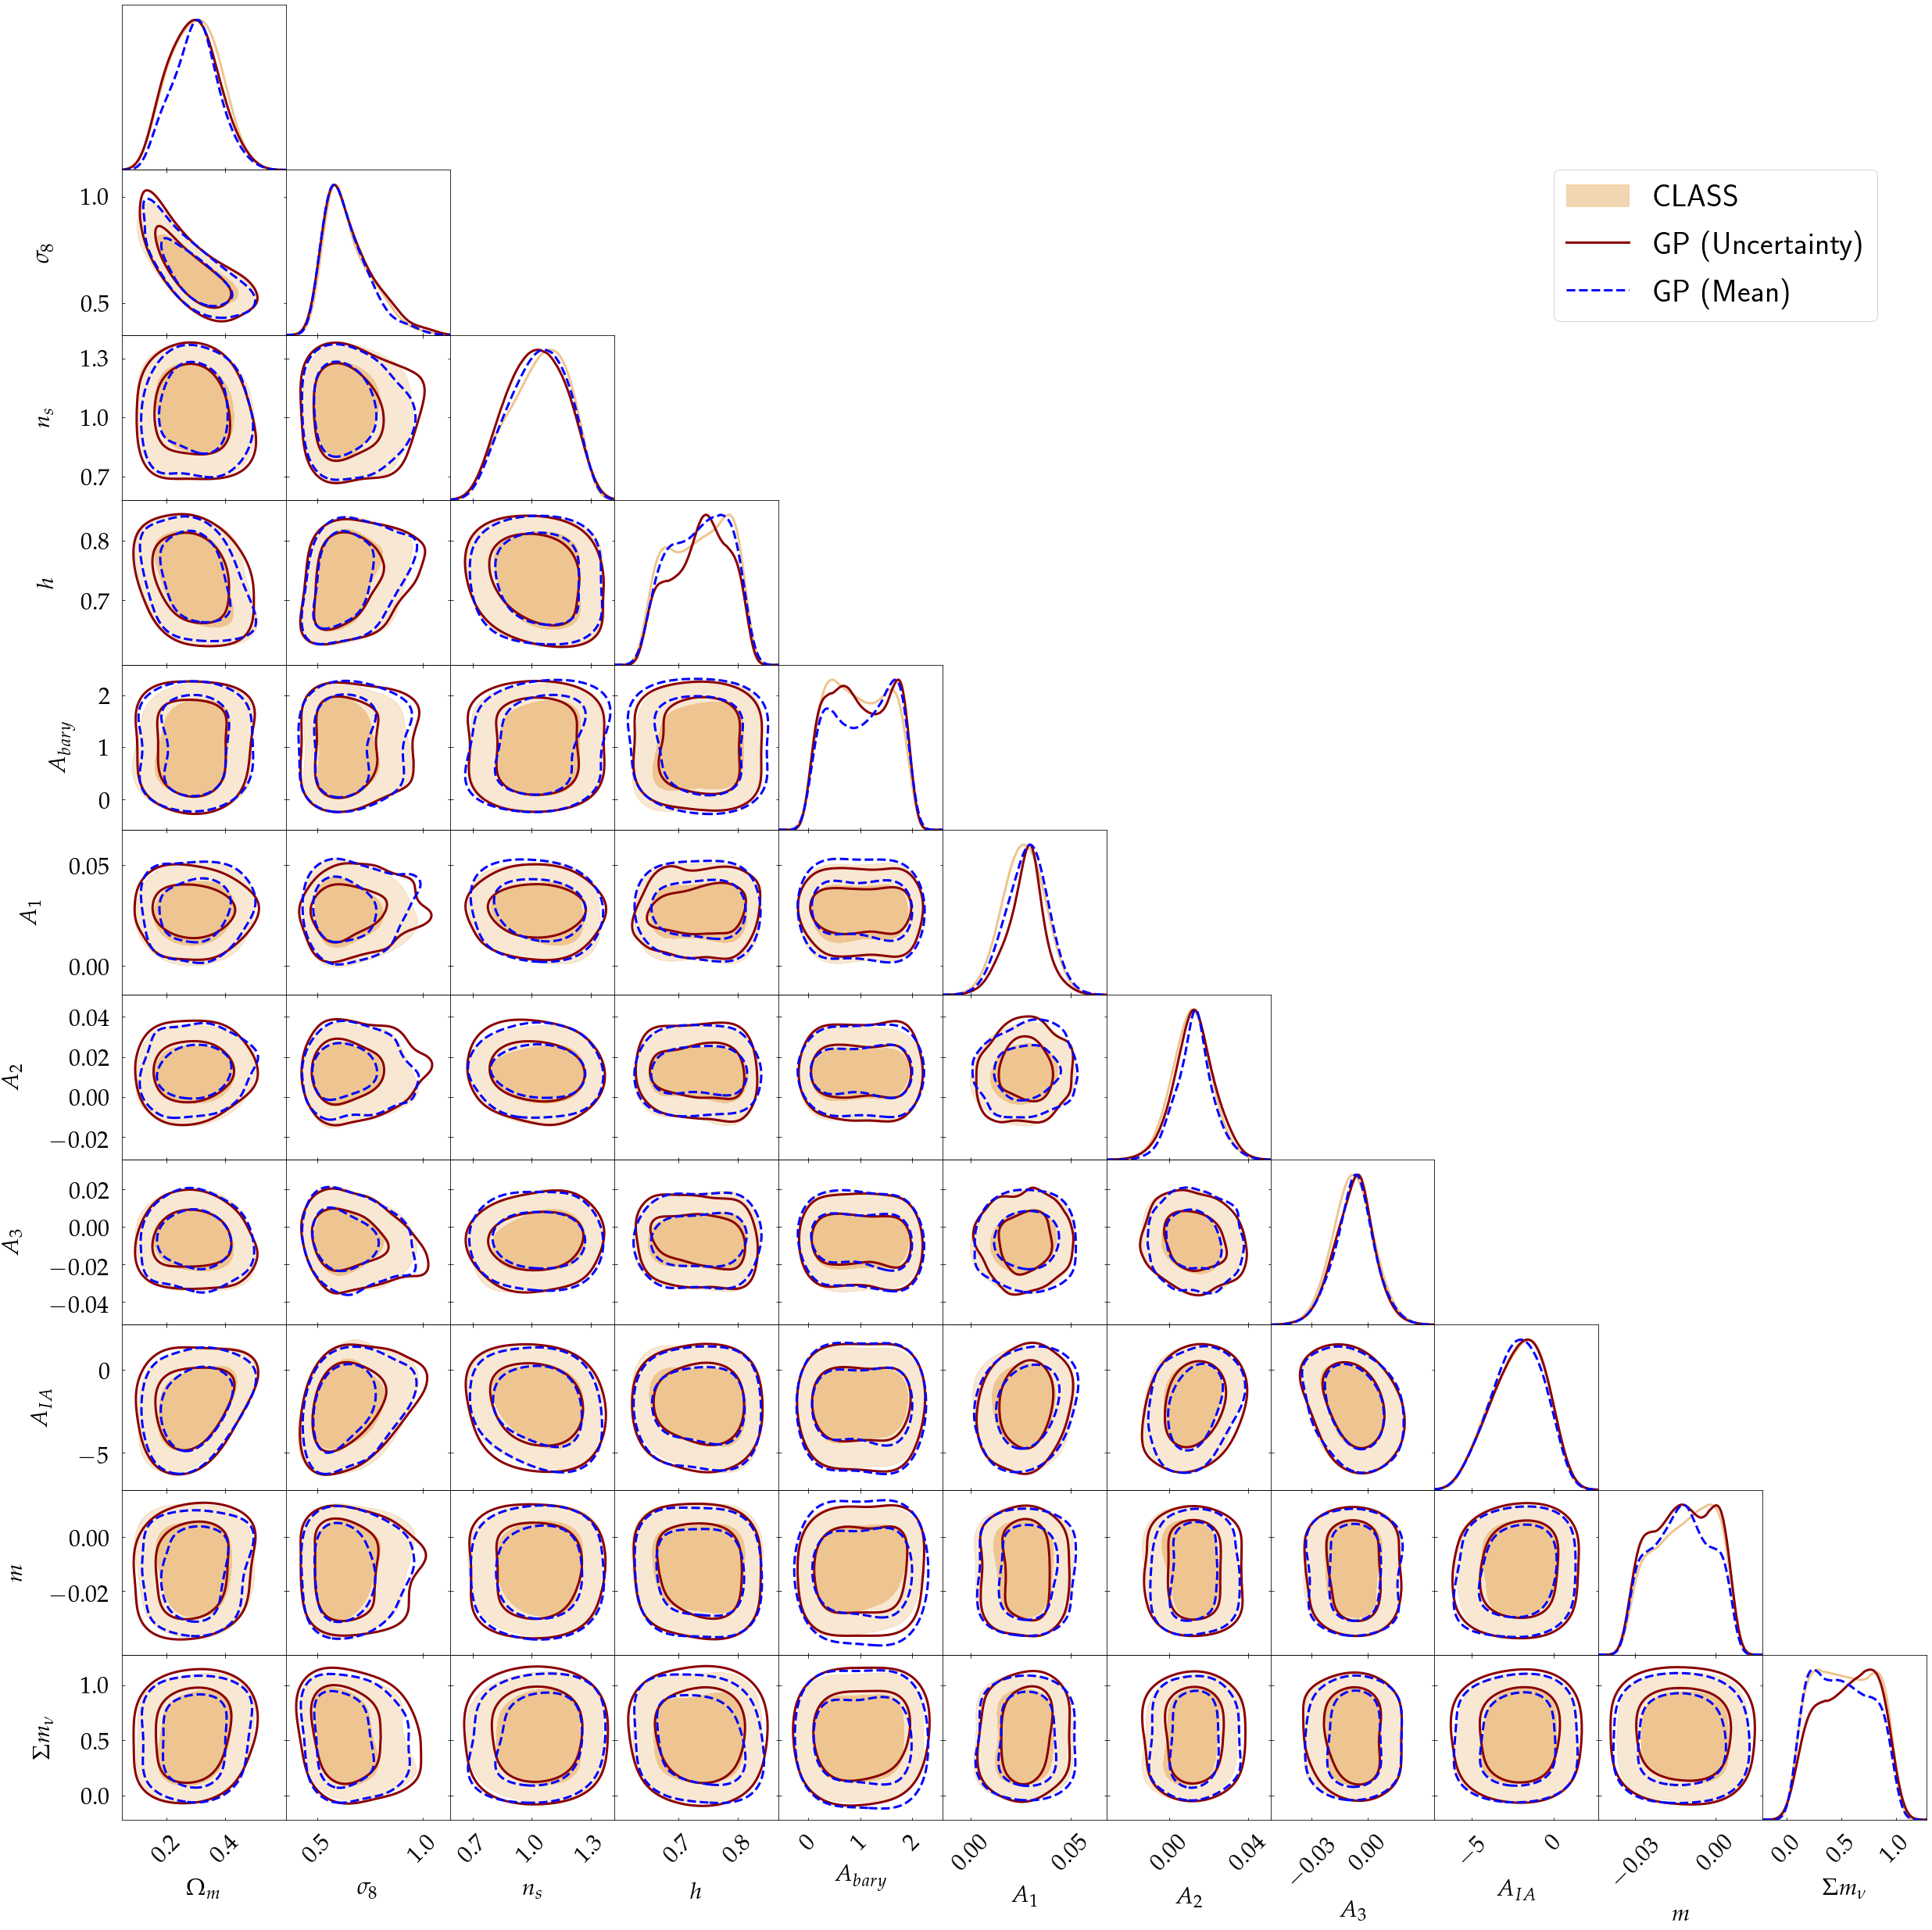

In [12]:
contours = np.array([0.68,0.95])
G = plots.getSubplotPlotter(subplot_size=3)
samples1.updateSettings({'contours': [0.68, 0.95]})
samples2.updateSettings({'contours': [0.68, 0.95]})
samples3.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples1], filled = True, line_args={'lw':3, 'color':sim_color}, contour_colors=[sim_color])
G.settings.num_plot_contours = 2
#G.settings.font_size = 25
plt.legend(handles=rec_leg, loc = 'best',prop={'size':40}, bbox_to_anchor=(0.7, 10.0), borderaxespad=0.)
G.settings.alpha_filled_add = alpha_tri
for i in range(0,11):
    for j in range(0, i+1):
        if i != j:
            ax = G.subplots[i,j]

            a, b = G.get_param_array(samples3, ['x'+str(j), 'x'+str(i)])
            density = G.sample_analyser.get_density_grid(samples3, a, b)
            density.contours = density.getContourLevels(contours)
            contour_levels = density.contours
            ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = gp_error_color, linewidths = 3) 

            a, b = G.get_param_array(samples2, ['x'+str(j), 'x'+str(i)])
            density = G.sample_analyser.get_density_grid(samples2, a, b)
            density.contours = density.getContourLevels(contours)
            contour_levels = density.contours
            ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = gp_mean_color, linewidths = 3, linestyles = '--') 
            
            ax.tick_params(axis = 'x', labelsize = 30, rotation=45, pad=15)
            ax.tick_params(axis = 'y', labelsize = 30, pad=15)
            ax.yaxis.label.set_size(30)
            ax.xaxis.label.set_size(30)
            ax.xaxis.labelpad = 40
            ax.yaxis.labelpad = 30
        else:
            ax = G.subplots[i,j]

            dense = samples3.get1DDensity('x'+str(i))
            dense.normalize(by='max')
            ax.plot(dense.x, dense.P, lw = 3, c = gp_error_color)
            
            dense = samples2.get1DDensity('x'+str(i))
            dense.normalize(by='max')
            ax.plot(dense.x, dense.P, lw =3, c = gp_mean_color, linestyle = '--')
           
            ax.tick_params(axis = 'x', labelsize = 30, rotation=45, pad=15)
            ax.tick_params(axis = 'y', labelsize = 30, pad=15)
            ax.yaxis.label.set_size(30)
            ax.xaxis.label.set_size(30)
            ax.xaxis.labelpad = 40
            ax.yaxis.labelpad = 30
plt.show()

### $S_{8}$ vs $\Omega_{m}$ Plot

In [13]:
legend_labels_  =['CLASS','GP (Ucertainty)', 'GP (Mean)']

names    = ["x%s"%i for i in range(2)]
labels   =  [r'$\Omega_{m}$', r'$S_{8}=\sigma_{8}\sqrt{\Omega_{m}/0.3}$']

samples_1 = MCSamples(samples=file_SO_class,names = names, labels = labels)
samples_2 = MCSamples(samples=file_SO_emu_mean,names = names, labels = labels)
samples_3 = MCSamples(samples=file_SO_emu_err,names = names, labels = labels)

Removed no burn in
Removed no burn in
Removed no burn in


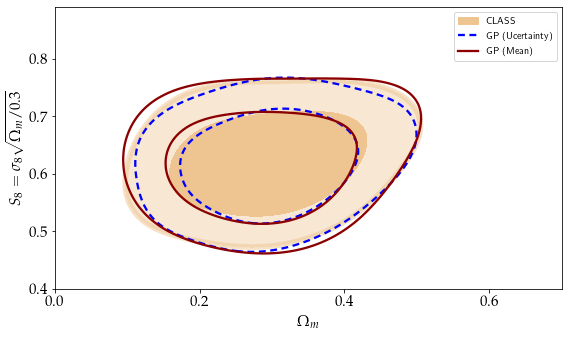

In [14]:
G = plots.getSinglePlotter(width_inch=8, ratio=3 / 5.)
G.settings.num_plot_contours = 2
samples2.updateSettings({'contours': [0.68, 0.95]})
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2.5
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.alpha_filled_add = 0.6
G.settings.legend_fontsize = 10
G.plot_2d([samples_1], 'x0', 'x1', filled=True, colors =[sim_color], lims = [0.0, 0.7, 0.4, 0.89])
G.plot_2d([samples_2], 'x0', 'x1', colors = [gp_mean_color], ls = ['--'], lims = [0.0, 0.7, 0.4, 0.89])
G.plot_2d([samples_3], 'x0', 'x1', colors = [gp_error_color], ls = ['-'], lims = [0.0, 0.7, 0.4, 0.89])
G.add_legend(legend_labels_, legend_loc='upper right');
plt.show()